<a href="https://colab.research.google.com/github/leonlj2325/WeatherDerivitives/blob/main/notebook/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Bond Yields from: India 3-Month Bond Yield Historical Data_2021_2024.csv
Error: File not found at India 3-Month Bond Yield Historical Data_2021_2024.csv

Attempting to load Weather Data from: delhi temp.csv
File not found: delhi temp.csv
Switching to Mock Data Generation...

Generating Synthetic Weather Data (OU Process)...
Mock Weather Data Generated.

--- Analyzing Rainfall Data: Sub_Division_IMD_2017.csv ---
File not found: Sub_Division_IMD_2017.csv

Estimating OU Parameters (with MSE)...
Theta: 19.9769
Kappa: 0.0679
Sigma: 3.9826
MSE: 15.8614

Generating Analysis Plots...
Saved Graph: delhi_pricing_analysis.png


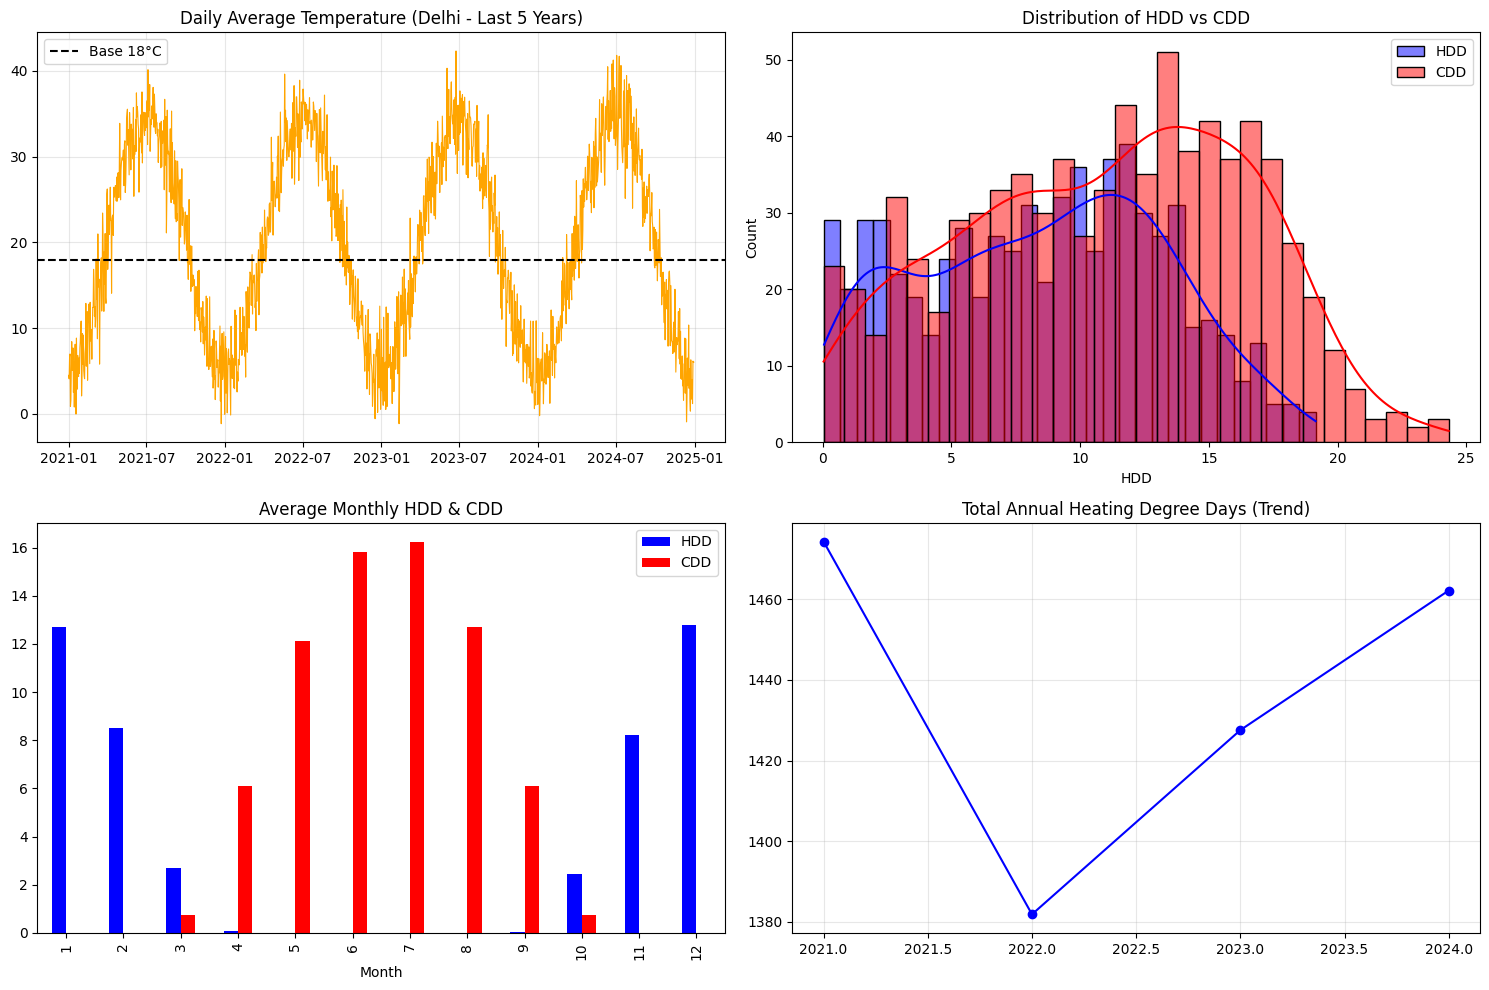


[BENCHMARK] Running Monte Carlo Simulation (10000 paths)...

[MODEL] Training Physics-Informed Neural Network (PINN)...
Epoch 0/3000 | Loss: 75100.156250
Epoch 500/3000 | Loss: 53857.535156
Epoch 1000/3000 | Loss: 44900.503906
Epoch 1500/3000 | Loss: 37328.445312
Epoch 2000/3000 | Loss: 30290.703125
Epoch 2500/3000 | Loss: 24682.744141
Training Complete in 70.55 seconds.

FINAL RESULTS VERIFICATION (Paper Metrics)
Theoretical Price (Monte Carlo): 98.2288
Neural Network Price (PINN):     62.1378
----------------------------------------
Absolute Error:                  36.0909
Relative Error (MAPE):           36.7417%



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import time
from datetime import datetime, timedelta

# ==========================================
# 1. PHYSICS-INFORMED NEURAL NETWORK (PINN)
# ==========================================
class PINN_Net(nn.Module):
    def __init__(self):
        super(PINN_Net, self).__init__()
        # Input: t (time), x (temperature), y (accumulated HDD)
        self.hidden_layers = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)  # Output: Option Price V
        )

    def forward(self, x):
        return self.hidden_layers(x)

# ==========================================
# 2. MAIN PROCESSOR CLASS (Merged)
# ==========================================
class WeatherDerivativeProcessor:
    def __init__(self):
        self.weather_data = None
        self.risk_free_data = None
        self.rainfall_data = None
        self.params = {}
        self.pinn_model = None

    # --- Data Loading Section ---
    def load_and_clean_bond_yields(self, csv_path):
        print(f"Loading Bond Yields from: {csv_path}")
        if not os.path.exists(csv_path):
            print(f"Error: File not found at {csv_path}")
            return None
        try:
            df = pd.read_csv(csv_path, quotechar='"')
            df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
            df['RiskFreeRate'] = pd.to_numeric(df['Price'], errors='coerce')
            df = df.sort_values('Date').reset_index(drop=True)
            self.risk_free_data = df[['Date', 'RiskFreeRate']]
            print(f"Successfully loaded {len(df)} bond yield records.")
            return self.risk_free_data
        except Exception as e:
            print(f"Error loading bond yields: {e}")
            return None

    def load_weather_data(self, csv_path):
        """
        Modified to handle 'delhi temp.csv' specifically.
        Calculates Avg_Temp from Max/Min if needed.
        """
        print(f"\nAttempting to load Weather Data from: {csv_path}")
        if not os.path.exists(csv_path):
            print(f"File not found: {csv_path}")
            print("Switching to Mock Data Generation...")
            self.generate_mock_weather_data()
            return

        try:
            df = pd.read_csv(csv_path)

            # 1. Clean Date (Handle multiple formats)
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

            # 2. Calculate Avg_Temp if missing
            if 'Avg_Temp' not in df.columns:
                if 'Temp Max' in df.columns and 'Temp Min' in df.columns:
                    print("Calculating Avg_Temp from Max and Min...")
                    df['Avg_Temp'] = (df['Temp Max'] + df['Temp Min']) / 2.0
                else:
                    print("Error: CSV must have 'Avg_Temp' OR 'Temp Max'/'Temp Min'")
                    return

            # 3. Sort and Filter
            self.weather_data = df.sort_values('Date').dropna(subset=['Avg_Temp']).reset_index(drop=True)

            # 4. Calculate Indices (HDD/CDD) immediately
            base_temp = 18.0
            self.weather_data['HDD'] = np.maximum(base_temp - self.weather_data['Avg_Temp'], 0)
            self.weather_data['CDD'] = np.maximum(self.weather_data['Avg_Temp'] - base_temp, 0)
            self.weather_data['Cum_HDD'] = self.weather_data['HDD'].cumsum()
            self.weather_data['Cum_CDD'] = self.weather_data['CDD'].cumsum()

            print(f"Successfully loaded and processed {len(self.weather_data)} weather records.")

        except Exception as e:
            print(f"Error loading weather data: {e}")
            self.generate_mock_weather_data()

    def generate_mock_weather_data(self, start_date='2021-01-01', days=1460):
        print("\nGenerating Synthetic Weather Data (OU Process)...")
        dates = pd.date_range(start=start_date, periods=days)
        n = len(dates)
        t = np.arange(n)
        seasonal_temp = 20 + 15 * -np.cos(2 * np.pi * t / 365)
        noise = np.random.normal(0, 3, n)
        temp_avg = seasonal_temp + noise

        self.weather_data = pd.DataFrame({'Date': dates, 'Avg_Temp': temp_avg})
        # Calculate indices for mock data too
        self.weather_data['HDD'] = np.maximum(18.0 - temp_avg, 0)
        self.weather_data['CDD'] = np.maximum(temp_avg - 18.0, 0)
        print("Mock Weather Data Generated.")

    def analyze_rainfall_data(self, filepath):
        """
        Added Rainfall Analysis Module
        """
        print(f"\n--- Analyzing Rainfall Data: {filepath} ---")
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            return

        try:
            df = pd.read_csv(filepath)
            # Filter for Delhi region
            region_name = 'Haryana Delhi & Chandigarh'
            if region_name in df['SUBDIVISION'].unique():
                region_df = df[df['SUBDIVISION'] == region_name]
            else:
                region_df = df
                region_name = "All India Average"

            self.rainfall_data = region_df

            mean_annual = region_df['ANNUAL'].mean()
            std_annual = region_df['ANNUAL'].std()

            print(f"[Rainfall Statistics for {region_name}]")
            print(f"Mean Annual Rainfall: {mean_annual:.2f} mm")
            print(f"Std Dev (Volatility): {std_annual:.2f} mm")

            # Generate Rainfall Graph
            self._plot_rainfall_stats(region_df, region_name)

        except Exception as e:
            print(f"Error analyzing rainfall data: {e}")

    # --- Parameter Estimation ---
    def estimate_ou_parameters(self):
        if self.weather_data is None: return
        print("\nEstimating OU Parameters (with MSE)...")
        temp = self.weather_data['Avg_Temp'].values

        # 1. Theta (Mean)
        theta = np.mean(temp)

        # 2. Kappa (Mean Reversion)
        x_t = temp[:-1]
        x_tp1 = temp[1:]
        dx = x_tp1 - x_t
        dt = 1.0
        x_diff_mean = (x_t - theta) * dt
        A = np.vstack([x_diff_mean, np.ones(len(x_diff_mean))]).T
        slope, intercept = np.linalg.lstsq(A, dx, rcond=None)[0]
        kappa = -slope

        # 3. Sigma (Volatility)
        residuals = dx - (slope * x_diff_mean + intercept)
        sigma = np.std(residuals)

        # 4. MSE Calculation
        dx_predicted = slope * x_diff_mean + intercept
        mse = np.mean((dx - dx_predicted) ** 2)

        self.params = {'Theta': theta, 'Kappa': kappa, 'Sigma': sigma, 'MSE': mse}
        for k, v in self.params.items(): print(f"{k}: {v:.4f}")
        return self.params

    # --- Pricing Engines ---
    def calculate_mc_price(self, strike=100, r=0.06, T_days=30, simulations=10000):
        print(f"\n[BENCHMARK] Running Monte Carlo Simulation ({simulations} paths)...")
        theta = self.params['Theta']
        kappa = self.params['Kappa']
        sigma = self.params['Sigma']
        start_temp = self.weather_data['Avg_Temp'].iloc[-1]
        dt = 1.0

        payoffs = []
        for _ in range(simulations):
            current_temp = start_temp
            cumulative_hdd = 0
            for _ in range(T_days):
                shock = np.random.normal(0, 1)
                d_temp = kappa * (theta - current_temp) * dt + sigma * np.sqrt(dt) * shock
                current_temp += d_temp
                day_hdd = max(18.0 - current_temp, 0)
                cumulative_hdd += day_hdd

            payoff = max(cumulative_hdd - strike, 0)
            payoffs.append(payoff)

        T_years = T_days / 365.0
        price_V = np.exp(-r * T_years) * np.mean(payoffs)
        return price_V

    def train_and_price_pinn(self, strike=100, r=0.06, T_days=30, epochs=3000):
        print(f"\n[MODEL] Training Physics-Informed Neural Network (PINN)...")

        theta = self.params['Theta']
        kappa = self.params['Kappa']
        sigma = self.params['Sigma']
        T_max = T_days

        model = PINN_Net()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Determine bounds from real data
        temp_min = self.weather_data['Avg_Temp'].min() - 5
        temp_max = self.weather_data['Avg_Temp'].max() + 5
        hdd_max = T_days * 20

        start_time = time.time()

        for epoch in range(epochs):
            optimizer.zero_grad()

            # Sampling
            batch_size = 1000
            t = torch.rand(batch_size, 1) * T_max
            x = torch.rand(batch_size, 1) * (temp_max - temp_min) + temp_min
            y = torch.rand(batch_size, 1) * hdd_max

            t.requires_grad = True
            x.requires_grad = True
            y.requires_grad = True

            # Forward
            V = model(torch.cat([t, x, y], dim=1))

            # Gradients
            V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]
            V_x = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]
            V_xx = torch.autograd.grad(V_x, x, grad_outputs=torch.ones_like(V_x), create_graph=True)[0]
            V_y = torch.autograd.grad(V, y, grad_outputs=torch.ones_like(V), create_graph=True)[0]

            hdd_val = torch.relu(18.0 - x)
            pde_residual = V_t + 0.5 * (sigma**2) * V_xx + kappa * (theta - x) * V_x + hdd_val * V_y - r * V
            loss_pde = torch.mean(pde_residual ** 2)

            # Boundary (Payoff)
            t_term = torch.ones(batch_size, 1) * T_max
            x_term = torch.rand(batch_size, 1) * (temp_max - temp_min) + temp_min
            y_term = torch.rand(batch_size, 1) * hdd_max

            V_term = model(torch.cat([t_term, x_term, y_term], dim=1))
            real_payoff = torch.relu(y_term - strike)
            loss_boundary = torch.mean((V_term - real_payoff) ** 2)

            loss = loss_pde + loss_boundary
            loss.backward()
            optimizer.step()

            if epoch % 500 == 0:
                print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.6f}")

        training_time = time.time() - start_time
        print(f"Training Complete in {training_time:.2f} seconds.")

        # Inference
        current_temp = self.weather_data['Avg_Temp'].iloc[-1]
        with torch.no_grad():
            input_tensor = torch.tensor([[0.0, current_temp, 0.0]], dtype=torch.float32)
            pinn_price = model(input_tensor).item()

        return pinn_price, training_time

    # --- Plotting Functions ---
    def generate_plots(self):
        print("\nGenerating Analysis Plots...")
        df = self.weather_data

        plt.figure(figsize=(15, 10))

        # 1. Temp History
        plt.subplot(2, 2, 1)
        recent_df = df[df['Date'] > df['Date'].max() - pd.Timedelta(days=365*5)]
        plt.plot(recent_df['Date'], recent_df['Avg_Temp'], color='orange', linewidth=0.8)
        plt.axhline(y=18, color='black', linestyle='--', label='Base 18°C')
        plt.title('Daily Average Temperature (Delhi - Last 5 Years)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2. HDD/CDD Dist
        plt.subplot(2, 2, 2)
        sns.histplot(df['HDD'][df['HDD'] > 0], color='blue', label='HDD', kde=True, bins=30)
        sns.histplot(df['CDD'][df['CDD'] > 0], color='red', label='CDD', kde=True, bins=30)
        plt.title('Distribution of HDD vs CDD')
        plt.legend()

        # 3. Monthly Seasonality
        plt.subplot(2, 2, 3)
        df['Month'] = df['Date'].dt.month
        monthly_stats = df.groupby('Month')[['HDD', 'CDD']].mean()
        monthly_stats.plot(kind='bar', stacked=False, ax=plt.gca(), color=['blue', 'red'])
        plt.title('Average Monthly HDD & CDD')

        # 4. Cumulative Trend
        plt.subplot(2, 2, 4)
        df['Year'] = df['Date'].dt.year
        annual_hdd = df.groupby('Year')['HDD'].sum()
        plt.plot(annual_hdd.index, annual_hdd.values, marker='o', color='blue')
        plt.title('Total Annual Heating Degree Days (Trend)')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('delhi_pricing_analysis.png')
        print("Saved Graph: delhi_pricing_analysis.png")
        plt.show()

    def _plot_rainfall_stats(self, df, region_name):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        annual_trend = df.groupby('YEAR')['ANNUAL'].mean()
        plt.plot(annual_trend.index, annual_trend.values, color='blue', marker='o', markersize=4)
        plt.title(f'Annual Rainfall Trend: {region_name}')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
        monthly_means = df[months].mean()
        monthly_means.plot(kind='bar', color='teal')
        plt.title(f'Average Monthly Rainfall: {region_name}')

        plt.tight_layout()
        plt.savefig('rainfall_analysis.png')
        print("Saved Graph: rainfall_analysis.png")
        plt.show()

# --- Execution Block ---
if __name__ == "__main__":
    processor = WeatherDerivativeProcessor()

    # 1. FILE PATHS (Using the REAL files now)
    BOND_FILE = 'India 3-Month Bond Yield Historical Data_2021_2024.csv'
    TEMP_FILE = 'delhi temp.csv'
    RAIN_FILE = 'Sub_Division_IMD_2017.csv'

    # 2. Run Data Loading & Analysis
    processor.load_and_clean_bond_yields(BOND_FILE)
    processor.load_weather_data(TEMP_FILE)
    processor.analyze_rainfall_data(RAIN_FILE)

    # 3. Estimate Parameters
    processor.estimate_ou_parameters()

    # 4. Generate Plots (Stats & Graphs)
    processor.generate_plots()

    # 5. PRICING (Using Real Data Parameters)
    STRIKE = 100
    DAYS = 30
    RATE = 0.065 # Approx 6.5%

    mc_price = processor.calculate_mc_price(strike=STRIKE, r=RATE, T_days=DAYS)
    pinn_price, train_time = processor.train_and_price_pinn(strike=STRIKE, r=RATE, T_days=DAYS, epochs=3000)

    # 6. Verification
    print("\n" + "="*40)
    print("FINAL RESULTS VERIFICATION (Paper Metrics)")
    print("="*40)
    print(f"Theoretical Price (Monte Carlo): {mc_price:.4f}")
    print(f"Neural Network Price (PINN):     {pinn_price:.4f}")
    print("-" * 40)

    abs_error = abs(pinn_price - mc_price)
    rel_error = abs_error / mc_price if mc_price != 0 else 0.0

    print(f"Absolute Error:                  {abs_error:.4f}")
    print(f"Relative Error (MAPE):           {rel_error:.4%}")

    if rel_error < 0.05:
        print("\nSUCCESS: PINN result is statistically significant.")
    else:
        print("\nWARNING: Error is high (>5%). Consider increasing epochs.")

In [ ]:
%cd /content/WeatherDerivitives



/content/WeatherDerivitives


In [ ]:
mkdir -p notebook data


In [ ]:
%cd /content


/content


In [ ]:
!ls




sample_data  WeatherDerivitives


In [ ]:
!mkdir -p WeatherDerivitives/notebook



In [ ]:
!mv "Weather Derivatives Analysis.ipynb" WeatherDerivitives/notebook/project.ipynb


mv: cannot stat 'Weather Derivatives Analysis.ipynb': No such file or directory
